# 1. Explore Dataset 

In [ ]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [ ]:
BUCKET = ''
PROJECT = ''
REGION = ''

In [ ]:
import os 
import shutil
import numpy as np
import tensorflow as tf

In [ ]:
os.environ['BUCKET']=BUCKET
os.environ['PROJECT']=PROJECT
os.environ['REGION']=REGION

In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

create a bucket if I havent created one:

In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [ ]:
# Create SQL query using natality data after the year 2000
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [ ]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

Let's write a query to find the unique values for each of the columns and the count of those values. This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [ ]:
# Create function that finds the number of records and the average weight for each value of the chosen column
#num_babies θα ειναι το πληθος των μωρών 
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
  """.format(column_name)
  return bigquery.Client().query(sql).to_dataframe()

In [ ]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
df = get_distinct_values('is_male')
df.plot(x='is_male', y='num_babies', kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');

In [ ]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');

In [ ]:
# Bar plot to see plurality(singleton, twins, etc.) with avg_wt linear and num_babies logarithmic
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', y='num_babies', logy=True, kind='bar');
df.plot(x='plurality', y='avg_wt', kind='bar');

In [ ]:
# Bar plot to see gestation_weeks with avg_wt linear and num_babies logarithmic
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', y='num_babies', logy=True, kind='bar');
df.plot(x='gestation_weeks', y='avg_wt', kind='bar');

# 2. Sample Dataset

In [ ]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1

<h2> Create ML dataset by sampling using BigQuery </h2>
<p>
Let's sample the BigQuery data to create smaller datasets.
</p>

In [ ]:
# Create SQL query using natality data after the year 2000
from google.cloud import bigquery
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

There are only a limited number of years and months in the dataset. Let's see what the hashmonths are.

In [ ]:
# Call BigQuery but GROUP BY the hashmonth 
# and see number of records for each group to enable us 
# to get the correct train and evaluation percentages
df = bigquery.Client().query("SELECT hashmonth, COUNT(weight_pounds) AS num_babies FROM (" + query + ") GROUP BY hashmonth").to_dataframe()
print("There are {} unique hashmonths.".format(len(df)))
df.head()


Here's a way to get a well distributed portion of the data in such a way that the test and train sets do not overlap:

In [ ]:
# Added the RAND() so that we can now subsample from each of the hashmonths to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + query + ") WHERE ABS(MOD(hashmonth, 4)) < 3 AND RAND() < 0.0005"
evalQuery = "SELECT * FROM (" + query + ") WHERE ABS(MOD(hashmonth, 4)) = 3 AND RAND() < 0.0005"
traindf = bigquery.Client().query(trainQuery).to_dataframe()
evaldf = bigquery.Client().query(evalQuery).to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))


<h2> Preprocess data using Pandas </h2>
<p>
Let's add extra rows to simulate the lack of ultrasound. In the process, we'll also change the plurality column to be a string.

In [ ]:
traindf.head()

In [ ]:
traindf.describe()

do the cleaning

In [ ]:
import pandas as pd
def preprocess(df):
  # users will have to tell us the mother's age
  # these were chosen because they are such good predictors and because these are easy enough to collect
  df = df[df.weight_pounds > 0]
  df = df[df.mother_age > 0]
  df = df[df.gestation_weeks > 0]
  df = df[df.plurality > 0]
  
  # modify plurality field to be a string
  twins_etc = dict(zip([1,2,3,4,5],
                   ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)']))
  df['plurality'].replace(twins_etc, inplace=True)
  
  # now create extra rows to simulate lack of ultrasound
  nous = df.copy(deep=True)
  nous.loc[nous['plurality'] != 'Single(1)', 'plurality'] = 'Multiple(2+)'
  nous['is_male'] = 'Unknown'
  
  return pd.concat([df, nous])

In [ ]:
traindf.head()
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
traindf.head()

In [ ]:
traindf.tail()

In [ ]:
traindf.describe()

<h2> Write out </h2>
<p>
In the final versions, we want to read from files, not Pandas dataframes. So, write the Pandas dataframes out as CSV files. 
Using CSV files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.


In [ ]:
traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

In [ ]:
%%bash
wc -l *.csv
head *.csv
tail *.csv


# 3. Creating a working tensorflow deep model 


In [ ]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]
TRAIN_STEPS = 1000

In [ ]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(value_column):
      columns = tf.compat.v1.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop(LABEL_COLUMN)
      return features, label
    
    # Create list of files that match pattern
    file_list = tf.compat.v1.gfile.Glob(filename)

    # Create dataset from file list
    dataset = (tf.compat.v1.data.TextLineDataset(file_list)  # Read text file
                 .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size=10*batch_size)
    else:
        num_epochs = 1 # end-of-input after this
 
    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset
  return _input_fn

next, define the feature columns 


In [ ]:
# Define feature columns
def get_wide_deep():
  # Define column types
  is_male,mother_age,plurality,gestation_weeks = \
      [\
          tf.feature_column.categorical_column_with_vocabulary_list('is_male', 
                      ['True', 'False', 'Unknown']),
          tf.feature_column.numeric_column('mother_age'),
          tf.feature_column.categorical_column_with_vocabulary_list('plurality',
                      ['Single(1)', 'Twins(2)', 'Triplets(3)',
                       'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
          tf.feature_column.numeric_column('gestation_weeks')
      ]

  # Discretize
  age_buckets = tf.feature_column.bucketized_column(mother_age, 
                      boundaries=np.arange(15,45,1).tolist())
  gestation_buckets = tf.feature_column.bucketized_column(gestation_weeks, 
                      boundaries=np.arange(17,47,1).tolist())

  # Sparse columns are wide, have a linear relationship with the output
  wide = [is_male,
          plurality,
          age_buckets,
          gestation_buckets]

  # Feature cross all the wide columns and embed into a lower dimension
  crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
  embed = tf.feature_column.embedding_column(crossed, 3)

  # Continuous columns are deep, have a complex relationship with the output
  deep = [mother_age,
          gestation_weeks,
          embed]
  return wide, deep

To predict with the TensorFlow model, we also need a serving input function. We will want all the inputs from our user.

In [ ]:
# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'is_male': tf.compat.v1.placeholder(tf.string, [None]),
        'mother_age': tf.compat.v1.placeholder(tf.float32, [None]),
        'plurality': tf.compat.v1.placeholder(tf.string, [None]),
        'gestation_weeks': tf.compat.v1.placeholder(tf.float32, [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [ ]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  wide, deep = get_wide_deep()
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNLinearCombinedRegressor(
                       model_dir = output_dir,
                       linear_feature_columns = wide,
                       dnn_feature_columns = deep,
                       dnn_hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

finally, train!

In [ ]:
shutil.rmtree('babyweight_trained', ignore_errors = True) # start fresh each time
tf.compat.v1.summary.FileWriterCache.clear()
train_and_evaluate('babyweight_trained')

The exporter directory contains the final model.

# 4.Preprocessing using Dataflow

In [ ]:
import datetime, os

def to_csv(rowdict):
  # Pull columns from BQ and create a line
  import hashlib
  import copy
  CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')

  # Create synthetic data where we assume that no ultrasound has been performed
  # and so we don't know sex of the baby. Let's assume that we can tell the difference
  # between single and multiple, but that the errors rates in determining exact number
  # is difficult in the absence of an ultrasound.
  no_ultrasound = copy.deepcopy(rowdict)
  w_ultrasound = copy.deepcopy(rowdict)

  no_ultrasound['is_male'] = 'Unknown'
  if rowdict['plurality'] > 1:
    no_ultrasound['plurality'] = 'Multiple(2+)'
  else:
    no_ultrasound['plurality'] = 'Single(1)'

  # Change the plurality column to strings
  w_ultrasound['plurality'] = ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality'] - 1]

  # Write out two rows for each input row, one with ultrasound and one without
  for result in [no_ultrasound, w_ultrasound]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data.encode('utf-8')).hexdigest()  # hash the columns to form a key
    yield str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'num_workers': 4,
      'max_num_workers': 5
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options = opts)
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) = 3'.format(query)

    (p 
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True))
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
    
preprocess(in_test_mode = False)

GCP -> Dataflow section to monitor

In [ ]:
#ooootan me to kalo teleiwsei h parapanw diadikasia, tha ertheis edw na kaneis ena ls sto cloud gia na deis 
#to arxeio pou einai ekei (oxi locally)
%%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

# 5. Training on Cloud AI Platform

distributed training on Cloud AI Platform (formerly known as Cloud ML Engine).

In [ ]:
os.environ['TFVERSION'] = '2.1'
#itf. _ _version_ _

In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/babyweight/preproc; then
  gsutil mb -l ${REGION} gs://${BUCKET}
  # copy canonical set of preprocessed files if you didn't do previous notebook
  gsutil -m cp -R gs://cloud-training-demos/babyweight gs://${BUCKET}
fi

# This command will copy over the CSV files from the cloud chain demos 
# babyweight example. From the babyweight folder in case you are unable to complete the prior lab. 

In [ ]:
%%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

#should be able to see the eval and training of the whole dataset

Now that we have the TensorFlow code working on a subset of the data, we can package the TensorFlow code up as a Python module and train it on Cloud AI Platform.

## Train on Cloud AI Platform
Training on Cloud AI Platform requires:
<ol>
<li>Making the code a Python package
<li>Using gcloud to submit the training code to Cloud AI Platform
</ol>
Ensure that the AI Platform API is enabled by going to this [link](https://console.developers.google.com/apis/library/ml.googleapis.com).

So what did two labs ago was we verify that our code will be working on a subset of the data. We verified that the code was able to learn and that there are some signal on our data. But now, let's package up this TensorFlow code as a Python module which would primarily involve adding a 
<ol>
<li>setup.py file, 
<li>and an init.py file.

Those are two requirements for Python packages. 

<li>And then we'll also add a task.py file which will be responsible for parsing user inputs.
<li>Then the model.py will be the same with our tensorflow notebook 
</ol>

## Lets package it up

So let's take a look at more detail at the structure. So if I go back to the root directory that we've been looking at there's a folder called babyweight.
<ol>
<li>**setup.py:** If we look at this, this contains essentially instructions on how to install our Python package, this is a requirement for all python packages.

the meat of this package is though is in the trainer directory. There's three files here:

<li>There's the empty **init.py** file which is just a requirement for Python packages.
<li>There's the **model.py** code, which is what we had already written in the prior labs that contains all the model logic. 
<li>And there's the task.py which contains argument parsing logic so we can have command line arguments that are input, that are used to execute the model that we've created.
So, for example by open up the task.py file, we can look at what's going on. We're going to input argparse library, and you're going to see a lot of this code is going to be argument parsing, right? So we're adding all sorts of arguments, training examples, batch size, number of embeddings, neuro network size. So the bulk of this code really is going to be parsing out user arguments, and then at the very end we're going to call our model code train_and_evaluate. Where is that located? Well, that's located in the model.py file.
</ol>

 The following code edits babyweight/trainer/task.py.

In [ ]:
%%writefile babyweight/trainer/task.py
import argparse
import json
import os

from . import model

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--bucket',
        help = 'GCS path to data. We assume that data is in gs://BUCKET/babyweight/preproc/',
        required = True
    )
    parser.add_argument(
        '--output_dir',
        help = 'GCS location to write checkpoints and export models',
        required = True
    )
    parser.add_argument(
        '--batch_size',
        help = 'Number of examples to compute gradient over.',
        type = int,
        default = 512
    )
    parser.add_argument(
        '--job-dir',
        help = 'this model ignores this field, but it is required by gcloud',
        default = 'junk'
    )
    parser.add_argument(
        '--nnsize',
        help = 'Hidden layer sizes to use for DNN feature columns -- provide space-separated layers',
        nargs = '+',
        type = int,
        default=[128, 32, 4]
    )
    parser.add_argument(
        '--nembeds',
        help = 'Embedding size of a cross of n key real-valued parameters',
        type = int,
        default = 3
    )

    
    parser.add_argument(
        '--train_examples',
        help = 'Number of examples (in thousands) to run the training job over. If this is more than actual # of examples available, it cycles through them. So specifying 1000 here when you have only 100k examples makes this 10 epochs.',
        type = int,
        default = 5000
    )    
    parser.add_argument(
        '--pattern',
        help = 'Specify a pattern that has to be in input files. For example 00001-of will process only one shard',
        default = 'of'
    )
    parser.add_argument(
        '--eval_steps',
        help = 'Positive number of steps for which to evaluate model. Default to None, which means to evaluate until input_fn raises an end-of-input exception',
        type = int,       
        default = None
    )
        
    
    args = parser.parse_args()
    arguments = args.__dict__

    
    arguments.pop('job_dir', None)
    arguments.pop('job-dir', None)

    ## assign the arguments to the model variables
    output_dir = arguments.pop('output_dir')
    model.BUCKET     = arguments.pop('bucket')
    model.BATCH_SIZE = arguments.pop('batch_size')
    model.TRAIN_STEPS = (arguments.pop('train_examples') * 100) / model.BATCH_SIZE
    model.EVAL_STEPS = arguments.pop('eval_steps')    
    print ("Will train for {} steps using batch_size={}".format(model.TRAIN_STEPS, model.BATCH_SIZE))
    model.PATTERN = arguments.pop('pattern')
    model.NEMBEDS= arguments.pop('nembeds')
    model.NNSIZE = arguments.pop('nnsize')
    print ("Will use DNN size of {}".format(model.NNSIZE))

    # Append trial_id to path if doing hptuning
    # an be removed if there s not using hyperparameter tuning
    output_dir = os.path.join(
        output_dir,
        json.loads(
            os.environ.get('TF_CONFIG', '{}')
        ).get('task', {}).get('trial', '')
    )

    # Run the training job
    model.train_and_evaluate(output_dir)

The following code edits babyweight/trainer/model.py.

In [ ]:
%%writefile babyweight/trainer/model.py
import shutil
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.logging.set_verbosity(tf.logging.INFO)

BUCKET = None  # set from task.py
PATTERN = 'of' # gets all files

# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

# Define some hyperparameters
TRAIN_STEPS = 10000
EVAL_STEPS = None
BATCH_SIZE = 512
NEMBEDS = 3
NNSIZE = [64, 16, 4]

# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(prefix, mode, batch_size):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return features, label
        
        # Use prefix to create file path
        file_path = 'gs://{}/babyweight/preproc/{}*{}*'.format(BUCKET, prefix, PATTERN)

        # Create list of files that match pattern
        file_list = tf.gfile.Glob(file_path)

        # Create dataset from file list
        dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                    .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this
 
        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()
    return _input_fn

# Define feature columns
def get_wide_deep():
    # Define column types
    is_male,mother_age,plurality,gestation_weeks = \
        [\
            tf.feature_column.categorical_column_with_vocabulary_list('is_male', 
                        ['True', 'False', 'Unknown']),
            tf.feature_column.numeric_column('mother_age'),
            tf.feature_column.categorical_column_with_vocabulary_list('plurality',
                        ['Single(1)', 'Twins(2)', 'Triplets(3)',
                         'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
            tf.feature_column.numeric_column('gestation_weeks')
        ]

    # Discretize
    age_buckets = tf.feature_column.bucketized_column(mother_age, 
                        boundaries=np.arange(15,45,1).tolist())
    gestation_buckets = tf.feature_column.bucketized_column(gestation_weeks, 
                        boundaries=np.arange(17,47,1).tolist())
      
    # Sparse columns are wide, have a linear relationship with the output
    wide = [is_male,
            plurality,
            age_buckets,
            gestation_buckets]
    
    # Feature cross all the wide columns and embed into a lower dimension
    crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
    embed = tf.feature_column.embedding_column(crossed, NEMBEDS)
    
    # Continuous columns are deep, have a complex relationship with the output
    deep = [mother_age,
            gestation_weeks,
            embed]
    return wide, deep

# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'is_male': tf.placeholder(tf.string, [None]),
        'mother_age': tf.placeholder(tf.float32, [None]),
        'plurality': tf.placeholder(tf.string, [None]),
        'gestation_weeks': tf.placeholder(tf.float32, [None]),
        KEY_COLUMN: tf.placeholder_with_default(tf.constant(['nokey']), [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

# create metric for hyperparameter tuning
def my_rmse(labels, predictions):
    pred_values = predictions['predictions']
    return {'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)}

def forward_features(estimator, key):
    def new_model_fn(features, labels, mode, config):
        spec = estimator.model_fn(features, labels, mode, config)
        predictions = spec.predictions
        predictions[key] = features[key]
        spec = spec._replace(predictions=predictions)
        return spec
    return tf.estimator.Estimator(model_fn=new_model_fn, model_dir=estimator.model_dir, config=estimator.config)

# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
    tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
    wide, deep = get_wide_deep()
    EVAL_INTERVAL = 300 # seconds

    
    run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                        keep_checkpoint_max = 3)
    
    
    estimator = tf.estimator.DNNLinearCombinedRegressor(
        model_dir = output_dir,
        linear_feature_columns = wide,
        dnn_feature_columns = deep,
        dnn_hidden_units = NNSIZE,
        config = run_config)
    
    # illustrates how to add an extra metric
    estimator = tf.estimator.add_metrics(estimator, my_rmse)
    # for batch prediction, you need a key associated with each instance
    estimator = forward_features(estimator, KEY_COLUMN)
    
  
    train_spec = tf.estimator.TrainSpec(
        input_fn = read_dataset('train', tf.estimator.ModeKeys.TRAIN, BATCH_SIZE),
        max_steps = TRAIN_STEPS)
    
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn, exports_to_keep=None)

   
    eval_spec = tf.estimator.EvalSpec(
        input_fn = read_dataset('eval', tf.estimator.ModeKeys.EVAL, 2**15),  # no need to batch in eval
        steps = EVAL_STEPS,
        start_delay_secs = 60, # start evaluating after N seconds
        throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
        exporters = exporter)
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

# Done. The code has been moved to a package.

So now that we've packaged up our Python code, let's test it out locally before we turn our model Cloud ML Engine. 
After moving the code to a package, make sure it works standalone. 

this step is ~3 minutes

In [ ]:
%%bash
echo "bucket=${BUCKET}"
rm -rf babyweight_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/babyweight
python -m trainer.task \
  --bucket=${BUCKET} \     .
  --output_dir=babyweight_trained \ 
  --job-dir=./tmp \ 
  --pattern="00000-of-" --train_examples=1 --eval_steps=1 



# Lets make some made up data to run the prediction locally to assess whether it produces predictions correctly.



And now let's write some test data, or rather, let's write some example features that we can use to make a prediction using the Predict API. 

The JSON below represents an input into your prediction model. Write the input.json file below with the next cell.

In [ ]:
%%writefile inputs.json 

{"key": "b1", "is_male": "True", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "g1", "is_male": "False", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}


In [ ]:
%%bash
sudo find "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine" -name '*.pyc' -delete



In [ ]:
%%bash
MODEL_LOCATION=$(ls -d $(pwd)/babyweight_trained/export/exporter/* | tail -1)
echo $MODEL_LOCATION1
gcloud ai-platform local predict --model-dir=$MODEL_LOCATION --json-instances=inputs.json



# So, now let's run it on Cloud ML Engine.

we can then submit the code, the training code to Cloud ML Engine

Once the code works in standalone mode, I can run it on Cloud AI Platform. Because this is on the entire dataset, it will take a while. The training run took about two hours . monitor the job from the GCP console in the Cloud AI Platform section.

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/babyweight/trained_model  
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S) 
echo $OUTDIR $REGION $JOBNAME 
gsutil -m rm -rf $OUTDIR  
gcloud ai-platform jobs submit training $JOBNAME \ 

  --region=$REGION \ 
  --module-name=trainer.task \ 
  --package-path=$(pwd)/babyweight/trainer \ 
  --job-dir=$OUTDIR \ 
  --staging-bucket=gs://$BUCKET \ 
  --scale-tier=STANDARD_1 \ 
  --runtime-version=2.1 \ 
  --python-version=3.7 \
  -- \ 
  --bucket=${BUCKET} \ 
  --output_dir=${OUTDIR} \ 
  --train_examples=20000 
  
  
  # the arguments before the --\ are specific to ML Engine. 
  
  


When I ran it, I used train_examples=20000. When training finished, I filtered in the Stackdriver log on the word "dict" and saw that the last line was:
<pre>
Saving dict for global step 5714290: average_loss = 1.06473, global_step = 5714290, loss = 34882.4, rmse = 1.03186
</pre>
The final RMSE was 1.03 pounds.

I can monitor it using the Cloud console:jobs


# Now hyperparameter search!

by creating hyperparam.yaml file.




In [ ]:
%%write file hyperparam.yaml
trainingInput:
    scaleTier:STANDARD_1
    hyperparameters:
        hyperparameterMetricTag: rmse
        goal: MINIMIZE
        maxTrials: 20 #We specify how many trials we're going to run it for
        maxParallelTrials: 5 #and then also how many trials we're going to run in parallel
        """In this case we have 5. Why might you want to set more ParallelTrials. 
        Well, it will go faster, right? When we run more jobs in parallel we'll finish earlier. 
        But if you set too many parallel trials you won't be able to learn from your prior trials 
        as it won't become a sequential learning process. 
        So it's important to not set too many max ParallelTrials, 
        otherwise you're just going to performing naive grid search."""
        enableTrialEarlyStopping: True
        params:  #We need to specify most importantly what are the parameters that we want to optimize over? 
        - parameterName: batch_size
          type: INTEGER
          minValue: 8 #we can specify a range for the different parameters we're interested in
          maxValue: 512
          scaleType: UNIT_LOG_SCALE
        - parameterName: n_embeds
          type: INTEGER
          minValue: 3
          maxValue: 530
          scaleType: UNIT_LINEAR_SCALE
        - parameterName: nnsize
          type: INTEGER
          minValue: 64
          maxValue: 512
          scaleType: UNIT_LOG_SCALE
        
                 
        
OUTDIR=gs://${BUCKET}/babyweight/trained_model
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/babyweight/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=2.1 \
  --python-version=3.7 \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=20000

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/babyweight/trained_model
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/babyweight/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=2.1 \
  --config = hyperparam.yaml \  
  --python-version=3.7 \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=20000

So if we go back to our jobs in ML Engine, you can look at the different types. So you'll notice that I already submitted a hyperparameter training job. So let's go ahead and look at it. So the hyperparameter logs contain a couple points of interest. <ol>
<li>it contains the information that we just specified in our hyperparameter.yaml like batch_size, number of embeds, etc.
<li>But perhaps the most important thing that it contains is the actual output of your results of your hyperparametering job: **Training Output**
    </ol>


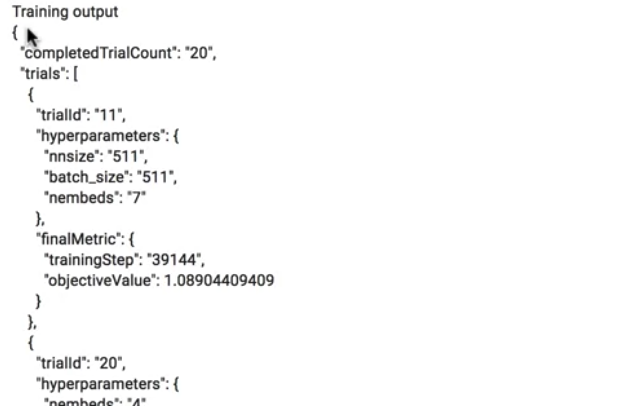



So in this case I can see:
out of all the 20 trials it sorts it by order of performance. 
So in this case, the best performing model had a neural network size of 511, a batch size of 511 and the number of embeds into 7. And the objective value was 1.09. 

After that, we got a pretty similar result using the slightly different setting. So generally you want to look at some of these top, if not, usually the top parameter combination and use that for your model going forward.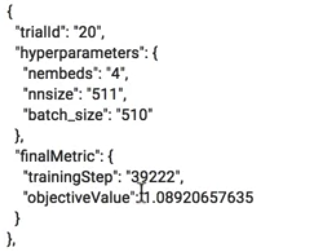

# And lets retrain it using the optimum parameters 


So finally, let's repeat our training using the tuned parameters.
This time with tuned parameters (note last line)

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/babyweight/trained_model_tuned
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/babyweight/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=2.1 \
  --python-version=3.7 \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=2000 --batch_size=35 --nembeds=16 --nnsize=281 


my model is currently stored in a Google Cloud Storage bucket, so I m  going to point ML Engine to my trained model which was specified by that model file and then Im  going to use that to serve predictions. 

## 6. DEPLOY !


In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/babyweight/trained_model; then
  gsutil mb -l ${REGION} gs://${BUCKET}
  # copy canonical model if you didn't do previous notebook
  gsutil -m cp -R gs://cloud-training-demos/babyweight/trained_model gs://${BUCKET}/babyweight/trained_model
fi

In [ ]:
%%bash
gsutil ls gs://${BUCKET}/babyweight/trained_model/export/exporter/


In [ ]:
%%bash
MODEL_NAME="babyweight" # i ll make a model called babyweight
MODEL_VERSION="ml_on_gcp" # this is what my version is gonna be called 
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/babyweight/trained_model/export/exporter/ | tail -1) #that is the time 
#stamp, which is actually the tail of the path found by gsutil ls 

echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

#gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME} I dont have anything deployed already
#so it commeneted out since there is nothing to delete

#gcloud ai-platform models delete ${MODEL_NAME}

# I ll go ahead and create the model now:
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
# and the version 
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Once the version has been created, I go to the GCP console and see that there is an ML model already deployed. 

**Deployment Done!**

This step is ~ a couple of minutes

<h2> Use model to predict (online prediction) </h2>
<p>
Send a JSON request to the endpoint of the service to make it predict a baby's weight. The order of the responses are the order of the instances.
 The next cell basically has the data in the form that you expected. So, make sure that when you're calling the model, these columns that you're specifying (mother_age, is_male etc etc) are the exact same columns and have appropriate types as you trained your model to expect the raw data.

In [ ]:
from oauth2client.client import GoogleCredentials
import requests
import json

MODEL_NAME = 'babyweight'
MODEL_VERSION = 'ml_on_gcp'

token = GoogleCredentials.get_application_default().get_access_token().access_token
api = 'https://ml.googleapis.com/v1/projects/{}/models/{}/versions/{}:predict' \
         .format(PROJECT, MODEL_NAME, MODEL_VERSION)
headers = {'Authorization': 'Bearer ' + token }
data = {
  'instances': [
    {
      'key': 'b1',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'key': 'g1',
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
    {
      'key': 'b2',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Triplets(3)',
      'gestation_weeks': 39
    },
    {
      'key': 'u1',
      'is_male': 'Unknown',
      'mother_age': 29.0,
      'plurality': 'Multiple(2+)',
      'gestation_weeks': 38
    },
  ]
}
response = requests.post(api, json=data, headers=headers)
print(response.content)


The predictions for the four instances were: 7.66, 7.22, 6.32 and 6.19 pounds respectively when I ran it (your results might be different).

<h2> Use model to predict (batch prediction) </h2>
<p>
Batch prediction is commonly used when you thousands to millions of predictions.
Create a file with one instance per line and submit using gcloud.

In [ ]:
%%writefile inputs.json
{"key": "b1", "is_male": "True", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "g1", "is_male": "False", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}

In [ ]:
%%bash
INPUT=gs://${BUCKET}/babyweight/batchpred/inputs.json
OUTPUT=gs://${BUCKET}/babyweight/batchpred/outputs
gsutil cp inputs.json $INPUT
gsutil -m rm -rf $OUTPUT 
gcloud ai-platform jobs submit prediction babypred_$(date -u +%y%m%d_%H%M%S) \
  --data-format=TEXT --region ${REGION} \
  --input-paths=$INPUT \
  --output-path=$OUTPUT \
  --model=babyweight --version=ml_on_gcp

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"). Copy of the License at http://www.apache.org/licenses/LICENSE-2.0 